# Carbon Assessment of Business Travels (Data Correction)

In [1]:
import pathlib
import pandas as pd
import geopandas as gpd
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

In [2]:
import warnings
warnings.simplefilter("ignore")

## Forewords

### Disclaimer

 > Data insights provided in this notebook are not validated and may certainly contain errors. They are shared for feedback only with no warranty or liability of any kind.

### Credits

Please refer (citation) to this preliminary report as follow:

 > Report [not validated]: *Carbon Assessment of Business Travels (Data Insights)*, Jean Landercy (SmartCampus), 2020-03-20

Additionally, also cite sources listed below.

### History

 - 2020-03-18: Started to explore Missions Dataset provided by ULB/DTAS/BEP;
 - 2020-03-20: First version of this report submitted to review;

### Sources

 - ULB/Faculty, Faculty mission: anonymized administrative forms (CSV);
 - ULB/DTAS/BEP, Travel Types Carbon Coefficient (Excel);
 - ArgGIS Hub, Country of the World (GeoJSON);
 - OSM, Nominatim Geocoding API (JSON);
 - OSM, Map Web Interface;
  

## Load datasets

In [3]:
travels = pd.read_excel('data/travels.xlsx')

In [4]:
travels.columns

Index(['travel_id', 'mission_id', 'from_geocodeid', 'from_citycleansed',
       'from_ISO2', 'from_city', 'from_lat', 'from_lon', 'from_accuracy',
       'from_confidence', 'to_geocodeid', 'to_citycleansed', 'to_ISO2',
       'to_city', 'to_lat', 'to_lon', 'to_accuracy', 'to_confidence', 'start',
       'stop', 'travel_type', 'acronym', 'faculty', 'elapsed', 'distance'],
      dtype='object')

### Tortuosity assessment

In [5]:
crook = pd.read_excel("data/crookness.xlsx").rename(columns={'mean': 'direct'})
crook = crook.dropna().drop(['from_city', 'to_city'], axis=1)

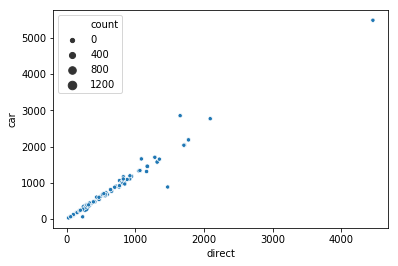

In [6]:
sns.scatterplot(x='direct', y='car', size='count', data=crook)

In [7]:
res1 = stats.siegelslopes(crook['car'], crook['direct'])
res1

(1.2381117602818152, -1.737580003270267)

In [8]:
res2 = stats.theilslopes(crook['car'], crook['direct'], 0.90)
res2

(1.2349523906804416,
 -5.2392289157743335,
 1.2177128860829995,
 1.2553971811374136)

In [9]:
res3 = stats.linregress(crook['direct'], crook['car'])
res3

LinregressResult(slope=1.2436894229514046, intercept=-3.1998439019467924, rvalue=0.9814827889315498, pvalue=2.639451484349886e-56, stderr=0.027842318489030245)

### Travel Type Classifier

In [10]:
missions = travels.groupby('mission_id').agg({
    'acronym': 'first', 'faculty': 'first',
    'start': 'first', 'stop':'first', 'elapsed': 'first', 'travel_type': 'first',
    'from_ISO2': 'first', 'to_ISO2': list, 'distance': 'sum',
}).reset_index()
missions['speed'] = missions['distance']/(24*missions['elapsed'])
missions['travel_type'] = missions['travel_type'].fillna('unknown')
missions['to_ISO2-1'] = missions['to_ISO2'].apply(lambda x: x[0])
missions

,mission_id,acronym,faculty,start,stop,elapsed,travel_type,from_ISO2,to_ISO2,distance,speed,to_ISO2-1
0,0,DECA,LTC,2010-05-28,2010-06-01,5,unknown,BE,"[GB, GB, BE]",810.745964,6.756216,GB
1,1,SIC,LTC,2010-06-22,2010-07-08,17,unknown,BE,"[GB, BE]",645.698894,1.582595,GB
2,2,SIC,LTC,2010-06-22,2010-07-08,17,unknown,BE,"[GB, BE]",645.698894,1.582595,GB
3,3,SIC,LTC,2010-07-12,2010-07-17,6,unknown,BE,"[GB, BE]",645.698894,4.484020,GB
4,4,SIC,LTC,2010-05-31,2010-06-01,2,unknown,BE,"[FR, BE]",528.587028,11.012230,FR
...,...,...,...,...,...,...,...,...,...,...,...,...
6125,6125,DECS,SBS,2020-02-20,2020-02-20,1,train,BE,"[GB, BE]",645.698894,26.904121,GB
6126,6126,DECS,SBS,2020-02-23,2020-02-28,6,train,BE,"[FR, FR, FR, BE]",1923.612609,13.358421,FR
6127,6127,L&L,LTC,2020-02-16,2020-02-18,3,train,BE,"[FR, BE]",1536.399657,21.338884,FR
6128,6128,DECS,SBS,2020-03-02,2020-03-03,2,train,NL,"[FR, NL]",860.923418,17.935905,FR


In [11]:
train  = missions.loc[~(missions['travel_type']=='unknown'),:]

In [12]:
tttrans = {
    'plane/short': 'plane',
    'plane/eco': 'plane',
    'car/gas': 'car',
    'car/diesel': 'car',
    'bus': 'car',
    'plane/first': 'plane'
}
train['travel_type'] = train['travel_type'].replace(tttrans)

In [13]:
train.loc[(train['travel_type']=='train')&(train['distance']>2000),'travel_type'] = 'plane'
train.loc[(train['travel_type']=='car')&(train['distance']>70),'travel_type'] = 'plane'

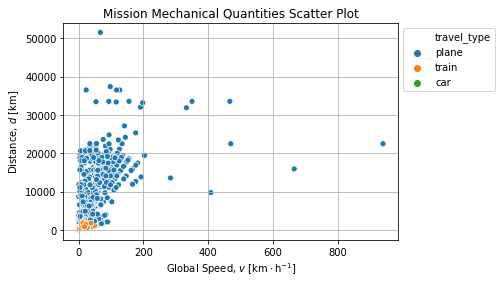

In [14]:
axe = sns.scatterplot(x='speed', y='distance', hue='travel_type', data=train)
axe.set_title("Mission Mechanical Quantities Scatter Plot")
axe.set_xlabel(r"Global Speed, $v$ $[\mathrm{km\cdot h^{-1}}]$")
axe.set_ylabel(r"Distance, $d$ $[\mathrm{km}]$")
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
axe.grid()

In [15]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [16]:
tkey = ['distance', 'speed', 'travel_type']
X = train[tkey]

In [17]:
y = pd.Categorical(X.pop("travel_type"))

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y.codes, test_size=0.25, random_state=20)

In [19]:
X_combined_std = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

In [20]:
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [21]:
knn.score(X_train, y_train)

0.8911070780399274

In [22]:
knn.score(X_test, y_test)

0.8206521739130435

In [23]:
plab = knn.predict(missions.loc[missions['travel_type']=='unknown',tkey].drop('travel_type', axis=1))
np.unique(plab)

array([0, 1, 2], dtype=int8)

In [24]:
q = missions['travel_type']=='unknown'
missions.loc[q,'travel_code'] = plab
missions.loc[~q,'travel_code'] = y.codes
missions['travel_code'] = missions['travel_code'].astype(int).replace({0: 'car', 1: 'plane', 2: 'train'})

In [25]:
missions

,mission_id,acronym,faculty,start,stop,elapsed,travel_type,from_ISO2,to_ISO2,distance,speed,to_ISO2-1,travel_code
0,0,DECA,LTC,2010-05-28,2010-06-01,5,unknown,BE,"[GB, GB, BE]",810.745964,6.756216,GB,train
1,1,SIC,LTC,2010-06-22,2010-07-08,17,unknown,BE,"[GB, BE]",645.698894,1.582595,GB,train
2,2,SIC,LTC,2010-06-22,2010-07-08,17,unknown,BE,"[GB, BE]",645.698894,1.582595,GB,train
3,3,SIC,LTC,2010-07-12,2010-07-17,6,unknown,BE,"[GB, BE]",645.698894,4.484020,GB,train
4,4,SIC,LTC,2010-05-31,2010-06-01,2,unknown,BE,"[FR, BE]",528.587028,11.012230,FR,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6125,6125,DECS,SBS,2020-02-20,2020-02-20,1,train,BE,"[GB, BE]",645.698894,26.904121,GB,train
6126,6126,DECS,SBS,2020-02-23,2020-02-28,6,train,BE,"[FR, FR, FR, BE]",1923.612609,13.358421,FR,train
6127,6127,L&L,LTC,2020-02-16,2020-02-18,3,train,BE,"[FR, BE]",1536.399657,21.338884,FR,train
6128,6128,DECS,SBS,2020-03-02,2020-03-03,2,train,NL,"[FR, NL]",860.923418,17.935905,FR,train


In [26]:
coef = pd.read_excel("data/carbon.xlsx", sheet_name="Aggregated")
coef

,travel_code_id,travel_code,crookness_coef,carbon_coef
0,0,car,1.24,0.170000
1,1,plane,1.00,0.116391
2,2,train,1.15,0.031076


In [27]:
final = missions.merge(coef)

In [28]:
final['cdistance'] = final['distance']*final['crookness_coef']
final['CO2'] = final['distance']*final['carbon_coef']

In [29]:
final = final.sort_values("mission_id")

In [30]:
final.to_excel("data/missions_ai.xlsx", index=False)